In [2]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Strategy for Supervised Learning**

The dataset is formatted as panel data, which is characterized as a collection of quantities obtained across multiple countries that are assembled over even intervals of time. Our focus is to develop a supervised learning model trained on historical data to forecast the "proportion of population using safely managed drinking water services" for future years.

In [4]:
# Read CSV as a Pandas DataFrame
df = pd.read_csv('/content/drive/My Drive/final_cleaned_df.csv')

df.head()

,GeoAreaName,TimePeriod,region,Access to electricity (% of population),Carbon dioxide emissions from fuel combustion (millions of tonnes),Carbon dioxide emissions from manufacturing industries per unit of manufacturing value added (kilogrammes of CO2 per constant 2015 United States dollars),Carbon dioxide emissions per unit of GDP PPP (kilogrammes of CO2 per constant 2021 United States dollars),GDP per capita (current US$),Gross capital formation (annual % growth),People practicing open defecation (% of population),People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population),Proportion of population covered by at least a 2G mobile network (%),"Proportion of population using safely managed drinking water services, by urban/rural (%)",Urban population (% of total population)
0,Afghanistan,2011,SAS,43.222019,372.258,0.9588,0.1186,591.190030,6.526510,17.669144,50.827846,36.425149,85.0,20.21288,23.948
1,Afghanistan,2012,SAS,69.099998,401.982,1.0220,0.1212,638.845852,7.870495,16.860403,53.403517,37.960809,88.0,21.12400,24.160
2,Afghanistan,2013,SAS,68.290649,412.778,0.9378,0.1152,624.315455,-5.403038,16.053442,56.014043,39.506018,88.6,22.03447,24.373
3,Afghanistan,2014,SAS,89.500000,450.262,1.0262,0.1198,614.223342,12.263828,15.248276,58.659374,41.060966,89.0,22.94430,24.587
4,Afghanistan,2015,SAS,71.500000,460.030,1.0408,0.1176,556.007221,9.642426,14.444733,61.339781,42.626023,89.2,23.85359,24.803


# Feature Selection & Engineering

From the previously developed correlation matrix, we observe that the following features have no correlation with our target variable and can be excluded from our model:

**Gross capital formation (annual % growth) (-0.07)**

**Carbon dioxide emissions from fuel combustion (millions of tonnes) (0.13)**

**Carbon dioxide emissions from manufacturing industries per unit of manufacturing value added (0.05)**

**Carbon dioxide emissions per unit of GDP PPP (kilogrammes of CO2 per constant 2021 United States dollars) (0.25)**



In [5]:
clean_df = df.drop(columns={"Carbon dioxide emissions from manufacturing industries per unit of manufacturing value added (kilogrammes of CO2 per constant 2015 United States dollars)",
                            "Gross capital formation (annual % growth)",
                            "Carbon dioxide emissions from fuel combustion (millions of tonnes)",
                            "Carbon dioxide emissions per unit of GDP PPP (kilogrammes of CO2 per constant 2021 United States dollars)",
                            "region"})

clean_df = clean_df.sort_values(by=["GeoAreaName", "TimePeriod"])
clean_df.head()

,GeoAreaName,TimePeriod,Access to electricity (% of population),GDP per capita (current US$),People practicing open defecation (% of population),People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population),Proportion of population covered by at least a 2G mobile network (%),"Proportion of population using safely managed drinking water services, by urban/rural (%)",Urban population (% of total population)
0,Afghanistan,2011,43.222019,591.190030,17.669144,50.827846,36.425149,85.0,20.21288,23.948
1,Afghanistan,2012,69.099998,638.845852,16.860403,53.403517,37.960809,88.0,21.12400,24.160
2,Afghanistan,2013,68.290649,624.315455,16.053442,56.014043,39.506018,88.6,22.03447,24.373
3,Afghanistan,2014,89.500000,614.223342,15.248276,58.659374,41.060966,89.0,22.94430,24.587
4,Afghanistan,2015,71.500000,556.007221,14.444733,61.339781,42.626023,89.2,23.85359,24.803


For our model, it is more appropriate to assume that present values of our target variable are likely influenced by past values of our independent features. This is because the relationship between our features and the target are often not instaneous in a real-world setting. For example, the effect of improving electricity access in 2011 might not be observed until 2012. To capture these effects, we will lag the independent features as part of our model preprocessing.

In addition, access to safely managed drinking water is likely to be strongly influenced by its value in the independent past. To capture the dynamic relationship between the part and present values of our target variable, we will also engineer a feature to add the lagged value of the target variable as a regressor in our model.


In [6]:
# List of features to lag
features_to_lag = [
    "Access to electricity (% of population)",
    "GDP per capita (current US$)",
    "People practicing open defecation (% of population)",
    "People using at least basic sanitation services (% of population)",
    "People using at least basic drinking water services (% of population)",
    "Proportion of population covered by at least a 2G mobile network (%)",
    "Proportion of population using safely managed drinking water services, by urban/rural (%)",
    "Urban population (% of total population)"
]

# Create lag features
for col in features_to_lag:
    clean_df[f"{col}_lag"] = clean_df.groupby("GeoAreaName")[col].shift(1)

# Drop rows with missing lag values
lagged_df = clean_df.dropna()

# Drop features not needed for modelling
lagged_df = lagged_df.drop(columns={"GeoAreaName",
                        "Access to electricity (% of population)",
                        "GDP per capita (current US$)",
                        "People practicing open defecation (% of population)",
                        "People using at least basic sanitation services (% of population)",
                        "People using at least basic drinking water services (% of population)",
                        "Proportion of population covered by at least a 2G mobile network (%)",
                        "Urban population (% of total population)"})

lagged_df.head()

,TimePeriod,"Proportion of population using safely managed drinking water services, by urban/rural (%)",Access to electricity (% of population)_lag,GDP per capita (current US$)_lag,People practicing open defecation (% of population)_lag,People using at least basic sanitation services (% of population)_lag,People using at least basic drinking water services (% of population)_lag,Proportion of population covered by at least a 2G mobile network (%)_lag,"Proportion of population using safely managed drinking water services, by urban/rural (%)_lag",Urban population (% of total population)_lag
1,2012,21.12400,43.222019,591.190030,17.669144,36.425149,50.827846,85.0,20.21288,23.948
2,2013,22.03447,69.099998,638.845852,16.860403,37.960809,53.403517,88.0,21.12400,24.160
3,2014,22.94430,68.290649,624.315455,16.053442,39.506018,56.014043,88.6,22.03447,24.373
4,2015,23.85359,89.500000,614.223342,15.248276,41.060966,58.659374,89.0,22.94430,24.587
5,2016,24.76222,71.500000,556.007221,14.444733,42.626023,61.339781,89.2,23.85359,24.803


In [7]:
# Descriptive Statistics
lagged_df.describe()

,TimePeriod,"Proportion of population using safely managed drinking water services, by urban/rural (%)",Access to electricity (% of population)_lag,GDP per capita (current US$)_lag,People practicing open defecation (% of population)_lag,People using at least basic sanitation services (% of population)_lag,People using at least basic drinking water services (% of population)_lag,Proportion of population covered by at least a 2G mobile network (%)_lag,"Proportion of population using safely managed drinking water services, by urban/rural (%)_lag",Urban population (% of total population)_lag
count,1953.00000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000
mean,2016.00000,66.535641,83.673430,17814.804593,7.661882,76.601699,88.052061,94.837855,66.227021,59.995118
std,2.58265,26.981095,26.594442,25919.117679,14.131902,27.902172,16.242328,8.429369,27.074421,23.951189
min,2012.00000,5.863130,2.684685,223.862876,0.000000,6.283375,35.776226,19.000000,5.834460,10.915000
25%,2014.00000,42.892100,74.843735,2406.910967,0.000000,59.325685,82.122976,93.391875,42.461940,41.162000
50%,2016.00000,68.281002,99.635490,7065.460372,0.610947,89.518003,95.747692,98.000000,68.149081,61.268000
75%,2018.00000,91.142854,100.000000,22608.452562,8.682066,98.055548,99.568102,99.500000,90.908117,79.388000
max,2020.00000,100.000000,100.000000,189487.147128,74.432002,100.000004,100.000005,100.000000,100.000000,100.000000


### Comparison of Approaches:

For our analysis, we will compare the performance of the following machine learning approaches on our test set:

1. Linear Model:

    *   Lasso Regression

2. Tree-based Model:

  *   Random Forest Regressor

3. Nearest Neighbors:

  *   K Nearest Neighbors Regression


<u>Model Assumptions:</u>

1.  All entries will be pooled to develop one global model
2.  Country specific effects not captured


In [8]:
# train-test split
lagged_df = lagged_df.sort_values(by=["TimePeriod"])
train_df = lagged_df[lagged_df["TimePeriod"] <= 2018]
test_df = lagged_df[lagged_df["TimePeriod"] > 2018]


In [9]:
# Define function to evalute models
def evaluate_models(models, x_train, y_train, x_test, y_test, cv, pg):

  # Set dictionaries to store results
  final_models = {}
  test_metrics = {}
  grid_results = {}
  predictions = {}

  # Iterate through each model and assess performance
  for name, model in models.items():

      # hypertuning
      param_grid = pg[name]
      grid = GridSearchCV(
        estimator=model['pipeline'],
        param_grid=param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
      )
      grid.fit(x_train, y_train)

      # Store grid results
      grid_results[name] = grid

      # Store best model
      final_models[name] = grid.best_estimator_

      # Predict on test set
      y_pred = grid.predict(x_test)
      predictions[name] = y_pred

      # Evaluate model performance
      mae = mean_absolute_error(y_test, y_pred)
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      r2 = r2_score(y_test, y_pred)
      mean_mae_cv = -grid.cv_results_['mean_test_score'][grid.best_index_]
      std_mae_cv = grid.cv_results_['std_test_score'][grid.best_index_]

      test_metrics[name] = {
          'Train MAE (mean)': mean_mae_cv,
          'Train MAE (std)': std_mae_cv,
          'MAE': mae,
          'RMSE': rmse,
          'R2 Score': r2
      }

  results_df = pd.DataFrame(test_metrics).T
  results_df.sort_values('MAE', inplace=True)
  return results_df, final_models, grid_results, predictions

In [10]:
# Train-test split
X_train = train_df.drop(columns=['Proportion of population using safely managed drinking water services, by urban/rural (%)','TimePeriod'])
Y_train = train_df['Proportion of population using safely managed drinking water services, by urban/rural (%)']

X_test = test_df.drop(columns=['Proportion of population using safely managed drinking water services, by urban/rural (%)','TimePeriod'])
Y_test = test_df['Proportion of population using safely managed drinking water services, by urban/rural (%)']

# Set time series object to prevent data leakage during cross validation
cv = TimeSeriesSplit(n_splits=5)

In [11]:
# Set pipeline for models
default_models = {
    'Lasso': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso(random_state=42))
        ])
    },
    'RandomForest': {
        'pipeline': Pipeline([
            ('regressor', RandomForestRegressor(random_state=42))
        ])
    },
    'KNN': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', KNeighborsRegressor())
        ])
    }
}

pg = {'Lasso':{}, 'RandomForest': {}, 'KNN':{}}
def_model_results, final_def_models, final_def_grid, def_y_pred = evaluate_models(default_models, X_train, Y_train, X_test, Y_test, cv, pg)
def_model_results.head()

,CV MAE (mean),CV MAE (std),MAE,RMSE,R2 Score
RandomForest,0.500377,0.086747,0.524567,0.740961,0.999226
Lasso,0.955621,0.084265,0.858699,1.089095,0.998327
KNN,2.624661,0.655613,1.750999,3.518878,0.982538


In [12]:
tuned_models = {
    'Lasso': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso(random_state=42))
        ])
    },
    'RandomForest': {
        'pipeline': Pipeline([
            ('regressor', RandomForestRegressor(random_state=42))
        ])
    }
}

pg = {
    'Lasso': {
        'regressor__alpha': [0.1, 1.0, 5.0, 10.0]
    },
    'RandomForest': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [5, 10, 15, 20, 25],
        'regressor__min_samples_split': [2, 4],
        'regressor__min_samples_leaf': [1, 2]
    }
}

tuned_model_results, final_tuned_models, final_tuned_grid, tuned_y_pred = evaluate_models(tuned_models, X_train, Y_train, X_test, Y_test, cv, pg)
tuned_model_results.head()

,CV MAE (mean),CV MAE (std),MAE,RMSE,R2 Score
Lasso,0.381722,0.082568,0.292523,0.503768,0.999642
RandomForest,0.497669,0.089325,0.502975,0.712764,0.999284


Lasso regression performs the best and will be used for additional analysis

### Training Curves

Assess how much training data is needed for good generalization ability

In [13]:
def LearningCurveAnalysis(ML_model):
  train_maes = []
  test_maes = []
  train_years = []
  len_train = []
  len_test = []

  for year in range(2013, 2020):

    # Train/Test split
    lc_train_df = lagged_df[lagged_df["TimePeriod"] <= year]
    lc_test_df = lagged_df[lagged_df["TimePeriod"] > year]

    len_train.append(len(lc_train_df))
    len_test.append(len(lc_test_df))

    target_col='Proportion of population using safely managed drinking water services, by urban/rural (%)'
    lc_X_train = lc_train_df.drop(columns=[target_col, 'TimePeriod'])
    lc_y_train = lc_train_df[target_col]
    lc_X_test = lc_test_df.drop(columns=[target_col, 'TimePeriod'])
    lc_y_test = lc_test_df[target_col]

    # Perform hypertuning with GridSearchCV
    grid = GridSearchCV(
      estimator=ML_model['Lasso']['pipeline'],
      param_grid={'regressor__alpha': [0.1, 1.0, 5.0, 10.0]},
      cv=cv,
      scoring='neg_mean_absolute_error',
      n_jobs=-1
    )
    grid.fit(lc_X_train, lc_y_train)

    # Get best lasso model
    best_lasso_model = grid.best_estimator_

    # Predict
    lc_y_train_pred = best_lasso_model.predict(lc_X_train)
    lc_y_test_pred = best_lasso_model.predict(lc_X_test)

    # Evaluate MAE
    #train_mae = mean_absolute_error(lc_y_train, lc_y_train_pred)
    train_mae = -grid.cv_results_['mean_test_score'][grid.best_index_]
    test_mae = mean_absolute_error(lc_y_test, lc_y_test_pred)

    # Append metrics
    train_maes.append(train_mae)
    test_maes.append(test_mae)
    train_years.append(year)

  return train_maes, test_maes, train_years, len_train, len_test

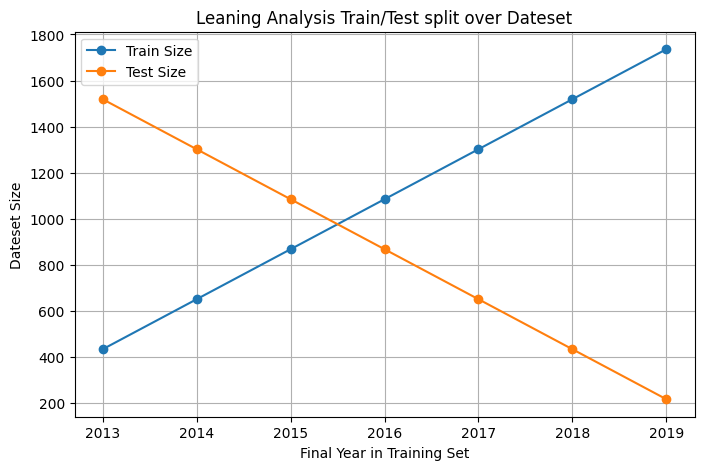

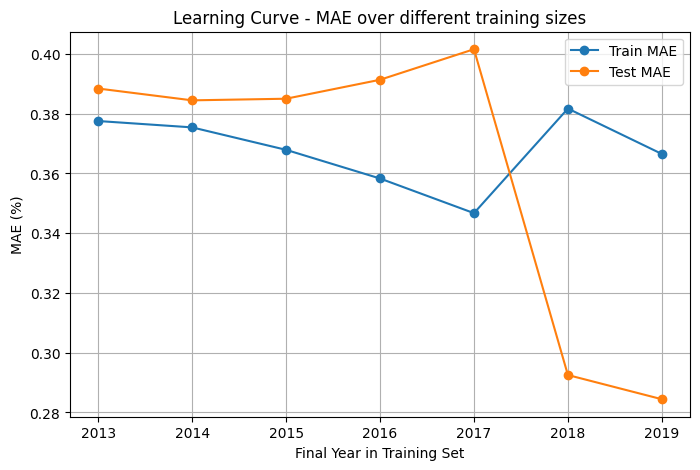

In [14]:
lc_model = {
    'Lasso': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso(random_state=42))
        ])
    }
}


lasso_train_maes, lasso_test_maes, lasso_train_years, lasso_len_train, lasso_len_test = LearningCurveAnalysis(lc_model)

# Plot train size over time

plt.figure(figsize=(8, 5))
plt.plot(lasso_train_years, lasso_len_train, label='Train Size', marker='o')
plt.plot(lasso_train_years, lasso_len_test, label='Test Size', marker='o')
plt.xlabel('Final Year in Training Set')
plt.ylabel('Dateset Size')
plt.title('Leaning Analysis Train/Test split over Dateset')
plt.legend()
plt.grid(True)
plt.show()

# Plot Lasso Learning Curve Analysis
plt.figure(figsize=(8, 5))
plt.plot(lasso_train_years, lasso_train_maes, label='Train MAE', marker='o')
plt.plot(lasso_train_years, lasso_test_maes, label='Test MAE', marker='o')
plt.xlabel('Final Year in Training Set')
plt.ylabel('MAE (%)')
plt.title('Learning Curve - MAE over different training sizes')
plt.legend()
plt.grid(True)
plt.show()

## Feature Analysis

Determine feature importance in dynamic modelling of panel data

In [15]:
def plot_shap_summary(shap_values, features, model_name):
  # SHAP summary plot
  shap.summary_plot(shap_values, features, show=False)

  # Plot chart
  plt.gcf().set_size_inches(12, 4)
  plt.title(f"SHAP Summary for {model_name}", fontsize=16)
  plt.tight_layout()
  plt.show()

ExactExplainer explainer: 435it [00:11,  6.93it/s]                         
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


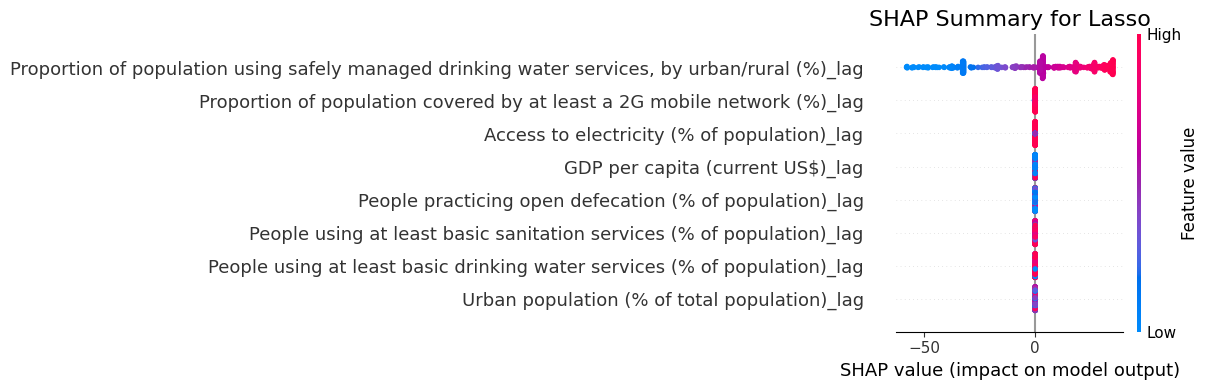

In [16]:
# SHAP plot for Lasso Model
explainer = shap.Explainer(final_tuned_models['Lasso'].predict, X_test)
shap_values = explainer(X_test)

plot_shap_summary(shap_values, X_test, "Lasso")




## Ablation Tests

Abalate lagged target to develop a static model approach and determine feature importance

In [19]:
# Drop lagged target
X_train_mod = X_train.drop(columns=['Proportion of population using safely managed drinking water services, by urban/rural (%)_lag'])
X_test_mod = X_test.drop(columns=['Proportion of population using safely managed drinking water services, by urban/rural (%)_lag'])

ablation_test_model = {
    'Lasso': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso(random_state=42))
        ])
    }
}

pg = {
    'Lasso': {
        'regressor__alpha': [0.1, 1.0, 5.0, 10.0]
    }
}


ab_tuned_model_results, ab_final_tuned_models, ab_final_tuned_grid, ab_tuned_y_pred = evaluate_models(ablation_test_model, X_train_mod, Y_train, X_test_mod, Y_test, cv, pg)
ab_tuned_model_results.head()

,CV MAE (mean),CV MAE (std),MAE,RMSE,R2 Score
Lasso,12.057064,0.425857,11.624139,15.218001,0.673408


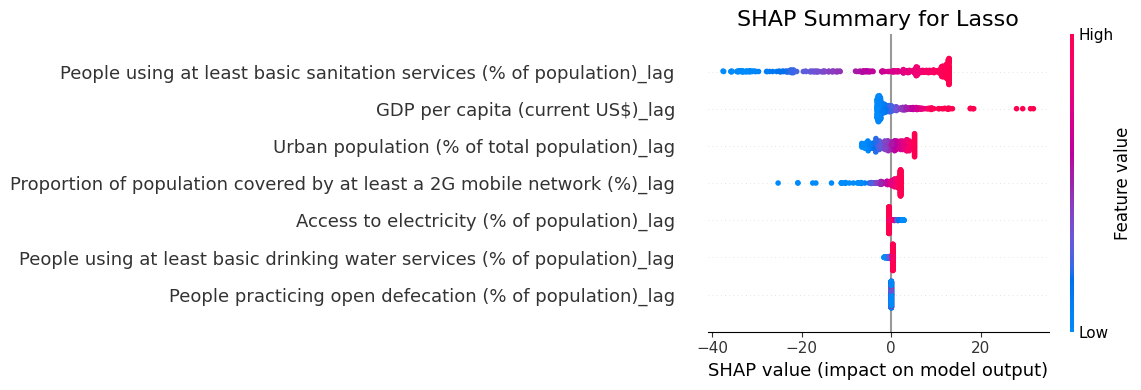

In [20]:
# Lasso Model
ab_explainer_lasso = shap.Explainer(ab_final_tuned_models['Lasso'].predict, X_test_mod)
ab_shap_values_lasso = ab_explainer_lasso(X_test_mod)

plot_shap_summary(ab_shap_values_lasso, X_test_mod, "Lasso")

### Sensitivity Analysis

Conduct sensitivity analysis to determine how sensitive the model is to hypertuning alpha

## Failure Analysis

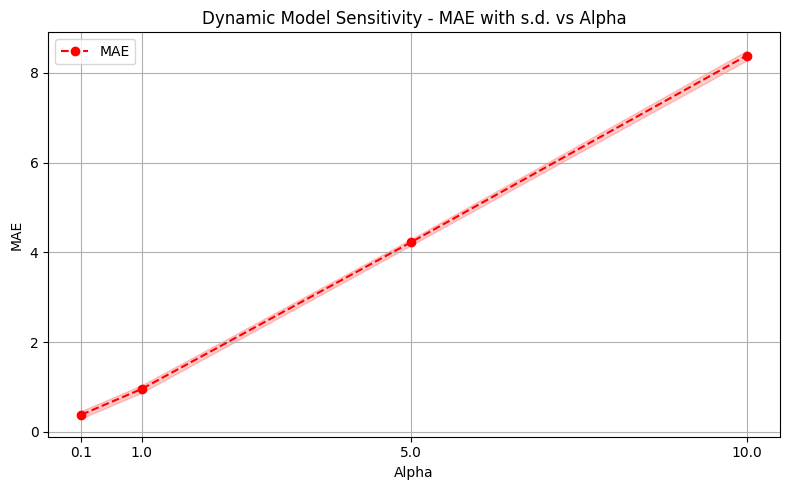

In [21]:
# Extract from Lasso Model
alphas = final_tuned_grid['Lasso'].cv_results_['param_regressor__alpha'].data
alphas = np.array(alphas, dtype=np.float64)
mean_mae = -final_tuned_grid['Lasso'].cv_results_['mean_test_score']
std_mae = final_tuned_grid['Lasso'].cv_results_['std_test_score']

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alphas, mean_mae, linestyle='--', marker='o', color='red', label='MAE')
plt.fill_between(alphas, mean_mae - std_mae, mean_mae + std_mae, color='red', alpha=0.2)
plt.title('Dynamic Model Sensitivity - MAE with s.d. vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('MAE')
plt.xticks(alphas)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



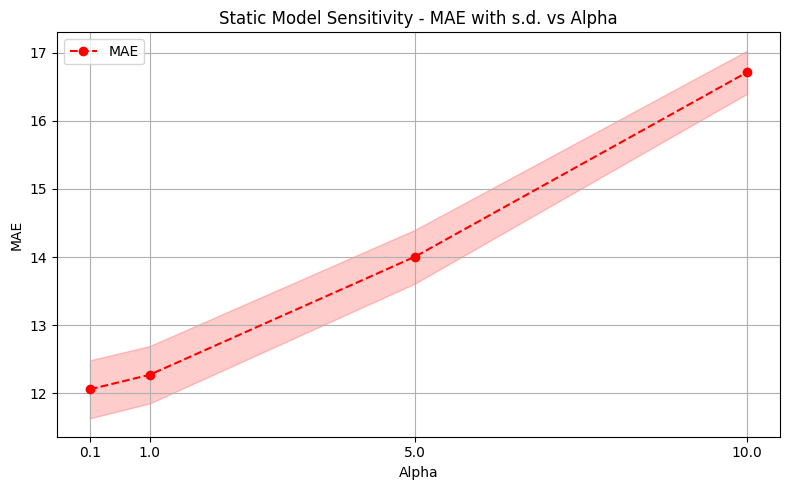

In [22]:
# Extract from Lasso Model
alphas = ab_final_tuned_grid['Lasso'].cv_results_['param_regressor__alpha'].data
alphas = np.array(alphas, dtype=np.float64)
mean_mae = -ab_final_tuned_grid['Lasso'].cv_results_['mean_test_score']
std_mae = ab_final_tuned_grid['Lasso'].cv_results_['std_test_score']

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alphas, mean_mae, linestyle='--', marker='o', color='red', label='MAE')
plt.fill_between(alphas, mean_mae - std_mae, mean_mae + std_mae, color='red', alpha=0.2)
plt.title('Static Model Sensitivity - MAE with s.d. vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('MAE')
plt.xticks(alphas)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Failure Analysis

Identify three poor predictions and analyze further


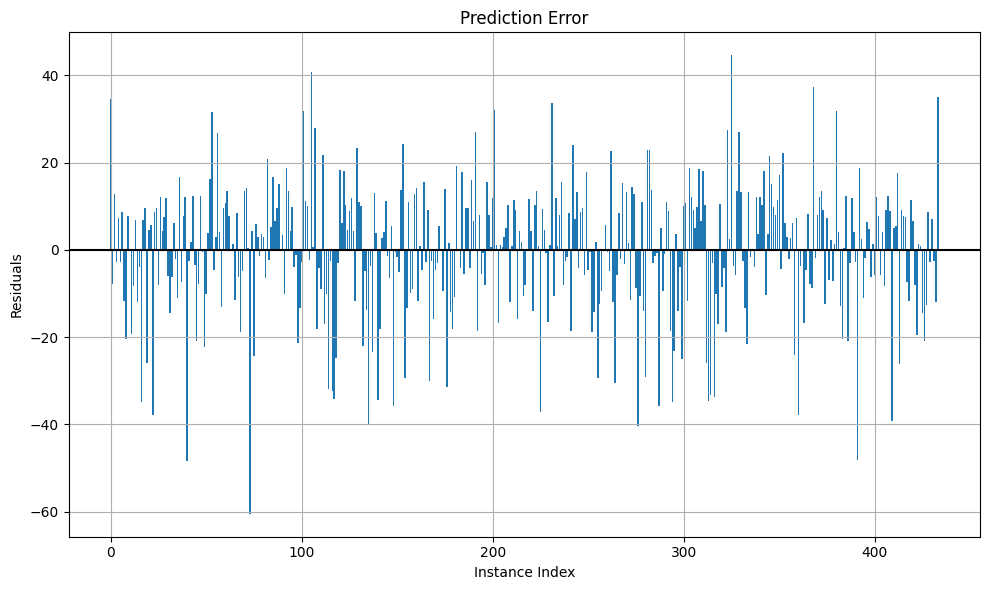

In [24]:
# Calculate residuals
residuals = Y_test - ab_tuned_y_pred['Lasso']

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(residuals)), residuals)
plt.axhline(0, color='black', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Static Model Prediction Error')
plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
abs_res = residuals.abs()
top_res = abs_res.sort_values(ascending=False)
lasso_preds = pd.Series(ab_tuned_y_pred['Lasso'], index=Y_test.index)

# Get Top Three Worst Predictions
true_values = Y_test.loc[top_res.index]
predictions = lasso_preds.loc[top_res.index]

worst_summary = pd.DataFrame({
    'True Value': true_values,
    'Predicted': predictions,
    'Residual': true_values - predictions
})

worst_summary.head(10)

,True Value,Predicted,Residual
2018,8.583260,69.051203,-60.467943
1698,31.954035,80.397081,-48.443045
1699,32.325254,80.537773,-48.212518
1529,67.278243,22.701316,44.576927
1528,67.031141,26.218721,40.812420
1959,29.492960,69.894401,-40.401441
1958,29.480890,69.450906,-39.970016
909,29.713920,68.810345,-39.096425
908,29.433920,67.236311,-37.802391
2019,8.625980,46.396106,-37.770126


First Failure Instance:

In [95]:
worst_summary.loc[2018]

,2018
True Value,8.583260
Predicted,69.051203
Residual,-60.467943


In [97]:
worst_index_labels = list(Y_test.index)
worst_index_labels.index(2018)

73

In [28]:
shap.initjs()

base_value = ab_shap_values_lasso.base_values[73]

shap.force_plot(
    base_value=base_value,
    shap_values=ab_shap_values_lasso.values[73],
    features=X_test_mod.iloc[73],
    feature_names=X_test_mod.columns
)


In [29]:
target = 'GeoAreaName'
n_df = df[df[target]=='Tuvalu']
n_df

,GeoAreaName,TimePeriod,region,Access to electricity (% of population),Carbon dioxide emissions from fuel combustion (millions of tonnes),Carbon dioxide emissions from manufacturing industries per unit of manufacturing value added (kilogrammes of CO2 per constant 2015 United States dollars),Carbon dioxide emissions per unit of GDP PPP (kilogrammes of CO2 per constant 2021 United States dollars),GDP per capita (current US$),Gross capital formation (annual % growth),People practicing open defecation (% of population),People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population),Proportion of population covered by at least a 2G mobile network (%),"Proportion of population using safely managed drinking water services, by urban/rural (%)",Urban population (% of total population)
2010,Tuvalu,2011,EAS,96.870750,858.831538,0.551000,0.229385,3688.637453,10.892260,7.190678,99.557860,83.827350,97.284000,8.18987,55.807
2011,Tuvalu,2012,EAS,97.671776,883.620000,0.560462,0.224538,3662.101658,8.684053,7.895975,99.885618,84.405213,96.918571,8.24321,56.815
2012,Tuvalu,2013,EAS,97.407677,915.392308,0.486846,0.219462,3559.544080,11.948542,8.482712,100.000000,84.172996,97.956000,8.29609,57.814
2013,Tuvalu,2014,EAS,97.703857,915.075385,0.451692,0.212538,3532.278312,0.799584,9.029695,100.000000,83.628876,95.985714,8.34760,58.786
2014,Tuvalu,2015,EAS,98.014885,907.003846,0.420231,0.204385,3316.664522,8.342560,8.955627,100.000000,83.659015,19.000000,8.39768,59.730
2015,Tuvalu,2016,EAS,97.300003,905.423077,0.394538,0.202000,3706.329903,4.532701,8.883833,100.000000,83.688227,20.000000,8.44630,60.645
2016,Tuvalu,2017,EAS,98.853836,923.562308,0.393231,0.202000,3978.676452,8.526694,8.814395,100.000000,83.716481,48.000000,8.49339,61.530
2017,Tuvalu,2018,EAS,99.065384,960.408462,0.378154,0.199538,4156.305128,5.140290,8.747152,100.000000,83.743842,96.821000,8.53906,62.387
2018,Tuvalu,2019,EAS,99.699997,975.498462,0.411385,0.197077,4652.350846,9.171022,6.144443,100.000000,81.437663,48.000000,8.58326,63.215
2019,Tuvalu,2020,EAS,99.689232,971.831538,0.394231,0.202615,4668.818743,-14.008670,5.945929,100.000000,81.674166,50.000000,8.62598,64.014


Second Failure Instance:

In [98]:
worst_summary.loc[1529]

,1529
True Value,67.278243
Predicted,22.701316
Residual,44.576927


In [99]:
worst_index_labels = list(Y_test.index)
worst_index_labels.index(1529)

325

In [30]:
shap.initjs()

base_value = ab_shap_values_lasso.base_values[325]

shap.force_plot(
    base_value=base_value,
    shap_values=ab_shap_values_lasso.values[325],
    features=X_test_mod.iloc[325],
    feature_names=X_test_mod.columns
)


In [31]:
z_df = df[df[target]=='Papua New Guinea']
z_df

,GeoAreaName,TimePeriod,region,Access to electricity (% of population),Carbon dioxide emissions from fuel combustion (millions of tonnes),Carbon dioxide emissions from manufacturing industries per unit of manufacturing value added (kilogrammes of CO2 per constant 2015 United States dollars),Carbon dioxide emissions per unit of GDP PPP (kilogrammes of CO2 per constant 2021 United States dollars),GDP per capita (current US$),Gross capital formation (annual % growth),People practicing open defecation (% of population),People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population),Proportion of population covered by at least a 2G mobile network (%),"Proportion of population using safely managed drinking water services, by urban/rural (%)",Urban population (% of total population)
1520,Papua New Guinea,2011,EAS,32.917320,858.831538,0.551000,0.229385,2406.910967,10.892260,14.273923,38.459824,18.675082,97.284000,64.516870,13.000
1521,Papua New Guinea,2012,EAS,35.275887,883.620000,0.560462,0.224538,2790.676303,8.684053,14.487855,39.210262,18.719877,96.918571,64.851533,12.982
1522,Papua New Guinea,2013,EAS,37.654285,915.392308,0.486846,0.219462,2729.888751,11.948542,14.700141,39.964855,18.769375,97.956000,65.190467,12.978
1523,Papua New Guinea,2014,EAS,40.050491,915.075385,0.451692,0.212538,2920.782986,0.799584,14.910684,40.723353,18.823276,95.985714,65.520721,12.988
1524,Papua New Guinea,2015,EAS,42.878220,907.003846,0.420231,0.204385,2679.346579,8.342560,15.119389,41.485508,18.881286,89.000000,65.838973,13.012
1525,Papua New Guinea,2016,EAS,49.400002,905.423077,0.394538,0.202000,2509.629637,4.532701,15.326161,42.251076,18.943111,89.000000,66.144758,13.050
1526,Papua New Guinea,2017,EAS,54.400002,923.562308,0.393231,0.202000,2695.249009,8.526694,15.530905,43.019808,19.008460,89.000000,66.451173,13.102
1527,Papua New Guinea,2018,EAS,55.727386,960.408462,0.378154,0.199538,2801.371393,5.140290,15.733390,43.791949,19.077404,96.821000,66.749812,13.169
1528,Papua New Guinea,2019,EAS,59.662975,975.498462,0.411385,0.197077,2820.306397,9.171022,15.933650,44.566762,19.149287,89.000000,67.031141,13.250
1529,Papua New Guinea,2020,EAS,60.400002,971.831538,0.394231,0.202615,2757.011019,-14.008670,16.131591,45.344018,19.223833,89.000000,67.278243,13.345


Third Failure Instance:

In [101]:
worst_summary.loc[759]

,759
True Value,100.00000
Predicted,90.19595
Residual,9.80405


In [100]:
worst_index_labels = list(Y_test.index)
worst_index_labels.index(759)

347

In [93]:
shap.initjs()

base_value = ab_shap_values_lasso.base_values[347]

shap.force_plot(
    base_value=base_value,
    shap_values=ab_shap_values_lasso.values[347],
    features=X_test_mod.iloc[347],
    feature_names=X_test_mod.columns
)

In [72]:
y_df = df[df[target]=='Gibraltar']
y_df


,GeoAreaName,TimePeriod,region,Access to electricity (% of population),Carbon dioxide emissions from fuel combustion (millions of tonnes),Carbon dioxide emissions from manufacturing industries per unit of manufacturing value added (kilogrammes of CO2 per constant 2015 United States dollars),Carbon dioxide emissions per unit of GDP PPP (kilogrammes of CO2 per constant 2021 United States dollars),GDP per capita (current US$),Gross capital formation (annual % growth),People practicing open defecation (% of population),People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population),Proportion of population covered by at least a 2G mobile network (%),"Proportion of population using safely managed drinking water services, by urban/rural (%)",Urban population (% of total population)
750,Gibraltar,2011,ECS,100.0,0.46,0.629476,0.221452,34001.305212,6.444182,0.0,100.0,100.0,99.468333,100.0,100.0
751,Gibraltar,2012,ECS,100.0,0.47,0.595643,0.209310,32271.791674,-2.362646,0.0,100.0,100.0,99.417895,100.0,100.0
752,Gibraltar,2013,ECS,100.0,0.50,0.596952,0.202500,34289.434919,-1.167489,0.0,100.0,100.0,99.678788,100.0,100.0
753,Gibraltar,2014,ECS,100.0,0.54,0.560452,0.188095,35300.112546,3.858560,0.0,100.0,100.0,99.278947,100.0,100.0
754,Gibraltar,2015,ECS,100.0,0.59,0.504119,0.183762,31092.495699,5.588977,0.0,100.0,100.0,100.000000,100.0,100.0
755,Gibraltar,2016,ECS,100.0,0.61,0.491333,0.183524,31531.660015,6.162277,0.0,100.0,100.0,100.000000,100.0,100.0
756,Gibraltar,2017,ECS,100.0,0.65,0.477643,0.179952,33112.687561,6.550511,0.0,100.0,100.0,100.000000,100.0,100.0
757,Gibraltar,2018,ECS,100.0,0.69,0.469119,0.174000,35637.583703,6.118454,0.0,100.0,100.0,100.000000,100.0,100.0
758,Gibraltar,2019,ECS,100.0,0.72,0.448095,0.164762,35052.757409,6.450018,0.0,100.0,100.0,100.000000,100.0,100.0
759,Gibraltar,2020,ECS,100.0,0.64,0.437857,0.162619,31100.739541,-7.725964,0.0,100.0,100.0,100.000000,100.0,100.0
